# 🎯 Análise de Campanha de Publicidade do WOW

Este projeto analisa os comentários públicos disponíveis no vídeo de uma transmissão ao vivo (live) publicada no YouTube, parte de uma campanha de marketing promovida pela Ubisoft para o jogo WOW. O objetivo é compreender a recepção do público, identificar sentimentos, temas recorrentes e padrões de engajamento com base nos comentários registrados no vídeo.

O dataset foi construído a partir de dados extraídos via API do YouTube, incluindo autor do comentário, número de likes, data e hora da publicação, além de colunas processadas para facilitar análises de texto e marcação de menções relevantes.

Abaixo segue o dicionário de dados utilizado na análise:

## 📊 Dicionário de Dados — Comentários da Live no YouTube

| Coluna             | Tipo      | Descrição                                                                 |
|--------------------|-----------|---------------------------------------------------------------------------|
| `Autor`            | string    | Nome de exibição do autor do comentário no YouTube.                       |
| `Comentario`       | string    | Texto original do comentário postado durante ou após a live.              |
| `Likes`            | int       | Número de curtidas recebidas pelo comentário.                             |
| `Hora`             | datetime  | Data e hora (UTC) em que o comentário foi publicado.                      |
| `Comentario_limpo` | string    | Comentário processado: sem stopwords, acentuação ou pontuação.           |
| `Mencoes_ubisoft`  | boolean   | Indica se o comentário menciona "Blizzard" (True/False).                   |
| `Mencoes_jogo`     | boolean   | Indica se o comentário menciona o jogo promovido na live (True/False).   |
| `Contem_risada`    | boolean   | Indica se o comentário contém expressões de riso como "kkk", "haha", etc.|


Carregar Bibliotecas:

In [5]:
# ====================== BIBLIOTECAS PADRÃO ======================
from datetime import datetime  # Manipulação de datas/tempo
import re  # Expressões regulares

# =================== BIBLIOTECAS DE TERCEIROS ================
# API e Coleta de Dados
from googleapiclient.discovery import build  # YouTube API

# Manipulação de Dados
import pandas as pd  # DataFrames e análise

# Visualização
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns  # Visualizações estatísticas

# Processamento de Linguagem Natural
from langdetect import DetectorFactory, detect  # Detecção de idioma
from unidecode import unidecode  # Normalização de caracteres
import nltk  # NLP tradicional
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Análise de sentimento
import spacy  # Processamento linguístico avançado

# Modelagem de Tópicos
from gensim import corpora, models  # LDA e vetorização

# Estatística e Análise
from scipy import stats  # Testes estatísticos

# Visualização Interativa
import pyLDAvis  # Visualização LDA
import pyLDAvis.gensim_models as gensimvis  # Integração com Gensim

# ====================== CONFIGURAÇÕES INICIAIS ======================
# Configurações do Matplotlib
plt.style.use('ggplot')  # Estilo de visualização
sns.set_palette("husl")  # Paleta de cores

# Configuração do LangDetect
DetectorFactory.seed = 0  # Reprodutibilidade

# Download de Recursos do NLTK (lexicon VADER)
nltk.download('vader_lexicon', quiet=True)  # Lexico para análise de sentimento



True

Configurar API e baixar dados:

In [ ]:
# Constantes
API_KEY = "API_KEY"  # Chave do Google Cloud
VIDEO_ID = "YT_VIDEO_ID"     # ID obtido no Passo 3
CSV_PATH = '/PATH/TO/dados/comentários.csv'

#def get_comentarios_portugues(video_id, api_key):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None
    total_pages = 0

    while True:
        if len(comments) >= 550:
            print("Alcançou 550 comentários. Finalizando coleta.")
            break

        try:
            request = youtube.commentThreads().list(
                part='snippet,replies',
                videoId=video_id,
                maxResults=100,
                pageToken=next_page_token,
                order='time',          # pega os comentários mais recentes primeiro
                textFormat='plainText'
            )
            response = request.execute()
        except Exception as e:
            print(f"Erro ao acessar a API: {e} — aguardando 10s")
            time.sleep(10)
            continue

        for item in response.get('items', []):
            if len(comments) >= 550:
                break

            # comentário principal
            top = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'autor': top['authorDisplayName'],
                'comentario': top['textDisplay'],
                'likes': top['likeCount'],
                'hora': datetime.strptime(top['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
            })

            # respostas, se houver
            for reply in item.get('replies', {}).get('comments', []):
                if len(comments) >= 550:
                    break
                r = reply['snippet']
                comments.append({
                    'autor': r['authorDisplayName'],
                    'comentario': r['textDisplay'],
                    'likes': r['likeCount'],
                    'hora': datetime.strptime(r['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
                })

        next_page_token = response.get('nextPageToken')
        total_pages += 1
        print(f"Página {total_pages} coletada. Total de comentários: {len(comments)}")

        if not next_page_token:
            print("Não há mais páginas. Fim da coleta.")
            break

        time.sleep(1)  # throttle
    
    return pd.DataFrame(comments)

IndentationError: unexpected indent (1435644722.py, line 9)

Verificar, carregar e salvar dados


In [7]:
df_comentarios = get_comentarios_portugues(VIDEO_ID, API_KEY)
df_comentarios.to_csv('/home/boto-cdr/Documentos/bs_NLP/dados/comentários.csv', index=False)

# Verificar e salvar
print(f"Comentários em português coletados: {len(df_comentarios)}")
df_comentarios.to_csv(CSV_PATH, index=False)
df_comentarios

# Verificar amostra
print("\nAmostra dos dados coletados:")
print(df_comentarios.sample(3, random_state=42)[['autor', 'comentario', 'hora']])


NameError: name 'get_comentarios_portugues' is not defined

Limpeza e processamento de dados:

FALTA: 
MAIUSCULA > MINUSCULA
TIRAR MINUTAGEM
RMV SEM COMENTARIOS


In [8]:
# Configurações iniciais
NOME_ARQUIVO = '/home/boto-cdr/Documentos/bs_NLP/dados/comentários.csv'  
NOME_SAIDA = '/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv'

# Carregar dados
try:
    df = pd.read_csv(NOME_ARQUIVO, parse_dates=['hora'])
except FileNotFoundError:
    print(f"Erro: Arquivo '{NOME_ARQUIVO}' não encontrado na pasta atual!")
    exit()

# Função de limpeza otimizada
def limpeza_estrategica(texto):
    # Passo 1: Normalização básica
    texto = str(texto)
    texto = re.sub(r'<a.*?>|<\/a>', '', texto)
    texto = re.sub(r'http\S+', '', texto)
    texto = unidecode(texto)
    
    # Passo 2: Padronização de termos-chave
    substituicoes = {
        r'\bpubli\b': 'publicidade',
        r'\bep\b': 'episodio',
        r'\bgame\b': 'jogo',
        r'\bkk+\b': ' [risada] ',
        r'\b(\w*creed\w*)\b': 'assassins creed'
    }
    
    for padrao, substituicao in substituicoes.items():
        texto = re.sub(padrao, substituicao, texto, flags=re.IGNORECASE)
    
    # Passo 3: Limpeza final
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto.lower()

# Processamento dos dados
print("\nProcessando comentários...")
df['comentario_limpo'] = df['comentario'].apply(limpeza_estrategica)


Processando comentários...


Análise Exploratória e Métricas de Engajamento

<>:12: DeprecationWarning: invalid escape sequence '\['
<>:12: DeprecationWarning: invalid escape sequence '\['
/tmp/ipykernel_7298/931306847.py:12: DeprecationWarning: invalid escape sequence '\['
  df['contem_risada'] = df['comentario_limpo'].str.contains('\[risada\]')



Estatísticas:
Média de likes: 15.3
Primeiro comentário: 2024-08-26 01:42:41
Último comentário: 2025-04-03 02:22:50

Dados processados salvos em: '/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv'

=== Métricas Chave ===
Total de comentários analisados: 501
Menções à Blizzard: 10 (2.0%)
Menções ao jogo: 15 (3.0%)
Comentários com risadas: 0 (0.0%)

=== Engajamento ===
Média geral de likes: 15.3
Média de likes com menção à Blizzard: 50.4
Média de likes com menção ao jogo: 3.1

1. Distribuição Temporal dos Comentários:
hora
0     10
1     88
2     52
3     47
4     20
5     12
6     10
7      9
8      8
9      9
10    14
11    26
12    28
13    23
14    15
15    17
16    27
17    17
18    22
19     8
20    12
21     9
22    11
23     7
Name: count, dtype: int64


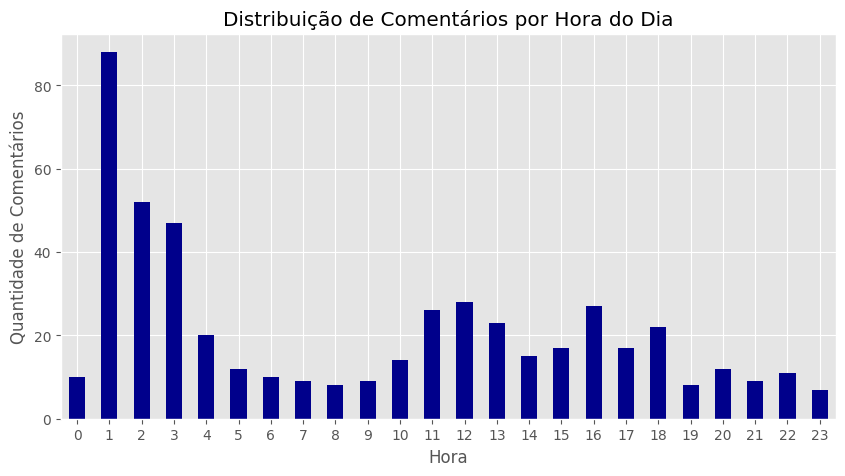


2. Estatísticas de Engajamento:
Média de Likes: 15.3
Máximo de Likes: 2296
Mediana de Likes: 0.0

3. Frequência de Menções:
Blizzard: 2.0%
Jogo: 3.0%
Risadas: 0.0%

4. Engajamento por Hora:
hora
0       0.400000
1      23.795455
2       6.423077
3       3.765957
4       2.400000
5     170.750000
6      12.900000
7       5.333333
8       9.125000
9       1.777778
10      0.500000
11      1.230769
12      1.250000
13      4.173913
14      1.800000
15    136.235294
16      3.629630
17      2.764706
18      0.409091
19      0.375000
20      0.500000
21      0.888889
22      0.636364
23      0.428571
Name: likes, dtype: float64


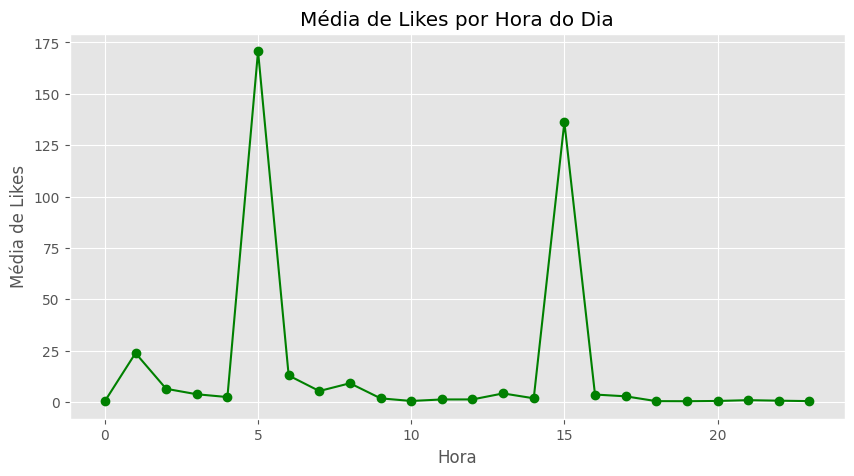


5. Top Autores por Engajamento:
autor
@worldofwarcraftbr      2296
@faye_tan               1957
@ch_jnts                 697
@Aleatoriamentejames     395
@MarcosMagnani           370
Name: likes, dtype: int64


In [ ]:
# Estatísticas básicas
print("\nEstatísticas:")
print(f"Média de likes: {df_comentarios['likes'].mean():.1f}")
print(f"Primeiro comentário: {df_comentarios['hora'].min()}")
print(f"Último comentário: {df_comentarios['hora'].max()}")

# Criar colunas de análise
df['mencoes_blizzard'] = df['comentario_limpo'].str.contains('blizzard', case=False)
df['mencoes_jogo'] = df['comentario_limpo'].str.contains('world of warcraft|jogo', case=False)
df['contem_risada'] = df['comentario_limpo'].str.contains('\[risada\]')

# Salvar resultados
df.to_csv(NOME_SAIDA, index=False)
print(f"\nDados processados salvos em: '{NOME_SAIDA}'")

# Continuação da análise após o processamento
print("\n=== Métricas Chave ===")
print(f"Total de comentários analisados: {len(df)}")
print(f"Menções à Blizzard: {df['mencoes_blizzard'].sum()} ({df['mencoes_blizzard'].mean():.1%})")
print(f"Menções ao jogo: {df['mencoes_jogo'].sum()} ({df['mencoes_jogo'].mean():.1%})")
print(f"Comentários com risadas: {df['contem_risada'].sum()} ({df['contem_risada'].mean():.1%})")

# Análise de engajamento
print("\n=== Engajamento ===")
print(f"Média geral de likes: {df['likes'].mean():.1f}")
print(f"Média de likes com menção à Blizzard: {df[df['mencoes_blizzard']]['likes'].mean():.1f}")
print(f"Média de likes com menção ao jogo: {df[df['mencoes_jogo']]['likes'].mean():.1f}")

# 1. Distribuição Temporal
print("\n1. Distribuição Temporal dos Comentários:")
distribuicao_horaria = df['hora'].dt.hour.value_counts().sort_index()
print(distribuicao_horaria)

plt.figure(figsize=(10,5))
distribuicao_horaria.plot(kind='bar', color='darkblue')
plt.title('Distribuição de Comentários por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=0)
plt.show()

# 2. Engajamento Básico
print("\n2. Estatísticas de Engajamento:")
print(f"Média de Likes: {df['likes'].mean():.1f}")
print(f"Máximo de Likes: {df['likes'].max()}")
print(f"Mediana de Likes: {df['likes'].median()}")

# 3. Frequência de Menções
print("\n3. Frequência de Menções:")
print(f"Blizzard: {df['mencoes_blizzard'].mean():.1%}")
print(f"Jogo: {df['mencoes_jogo'].mean():.1%}")
print(f"Risadas: {df['contem_risada'].mean():.1%}")

# 4. Engajamento por Hora
print("\n4. Engajamento por Hora:")
engajamento_hora = df.groupby(df['hora'].dt.hour)['likes'].mean()
print(engajamento_hora)

plt.figure(figsize=(10,5))
engajamento_hora.plot(kind='line', marker='o', color='green')
plt.title('Média de Likes por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Média de Likes')
plt.grid(True)
plt.show()

# 5. Top Autores
print("\n5. Top Autores por Engajamento:")
top_autores = df.groupby('autor')['likes'].sum().nlargest(5)
print(top_autores)


Correlação entre tamanho do texto e like:



Correlação de Pearson: 0.08

6. Relação entre Comprimento e Likes:
Correlação de Pearson: 0.08


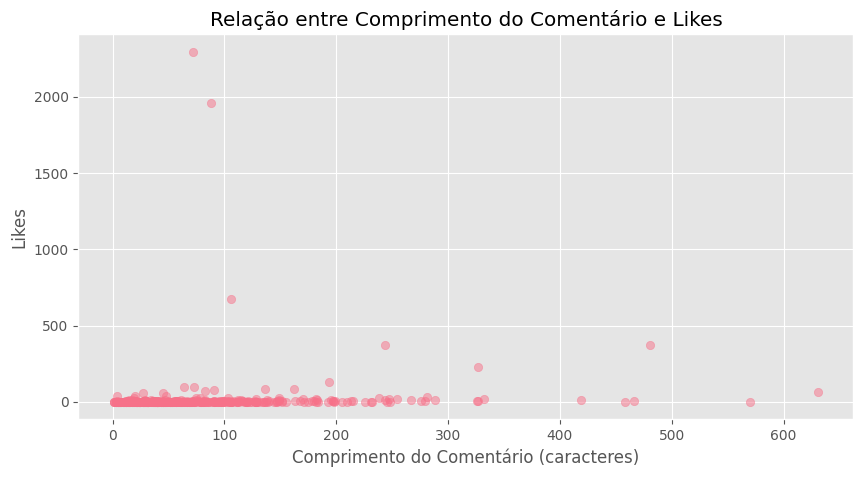

In [9]:
# 1. Cria a coluna 'comprimento' com o tamanho de cada comentário
df['comprimento'] = df['comentario'].str.len()

# 2. Agora calcula a correlação de Pearson entre comprimento e likes
correlacao = df['comprimento'].corr(df['likes'])
print(f"Correlação de Pearson: {correlacao:.2f}")

# 6. Relação Texto-Likes
print("\n6. Relação entre Comprimento e Likes:")
correlacao = df['comprimento'].corr(df['likes'])
print(f"Correlação de Pearson: {correlacao:.2f}")

plt.figure(figsize=(10,5))
plt.scatter(df['comprimento'], df['likes'], alpha=0.5)
plt.title('Relação entre Comprimento do Comentário e Likes')
plt.xlabel('Comprimento do Comentário (caracteres)')
plt.ylabel('Likes')
plt.grid(True)
plt.show()

1. Análise de Sentimento com VADER


Primeiras linhas do DataFrame:
                  autor                                         comentario  \
0         @AlvaroWilian                          51:30 GOLD. PEDRA DE GOLD   
1                @jetsp              Faye_tan, fazendo cosplay de smzinho?   
2           @lucianoxs6                                            2:01:01   
3  @guilhermedematos767  descanse em paz ronaldinho, tao novo e já foi ...   
4       @thyagojose9589  Sabrina Carpinteira do complexo de Israel kkkk...   

   likes                hora  \
0      0 2025-04-03 02:22:50   
1      0 2025-03-19 14:38:34   
2      0 2024-11-23 16:07:29   
3      0 2024-11-18 20:55:31   
4      0 2024-11-14 15:43:50   

                                    comentario_limpo  mencoes_blizzard  \
0                           51 30 gold pedra de gold             False   
1                faye_tan fazendo cosplay de smzinho             False   
2                                            2 01 01             False   
3  descans

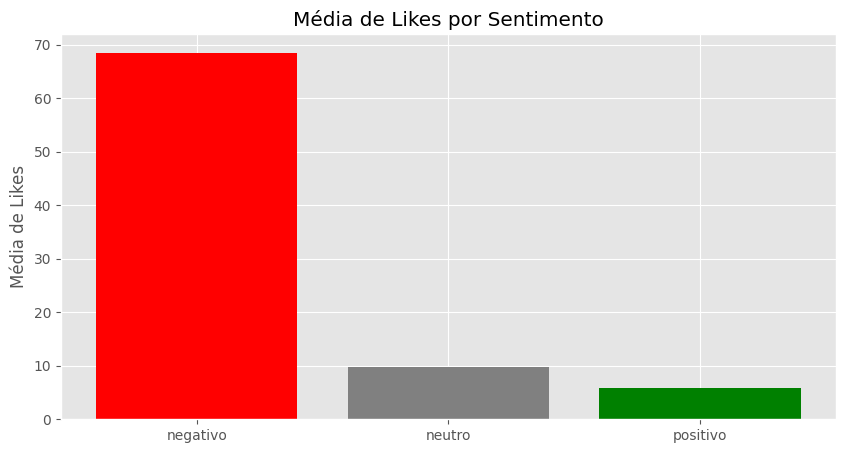

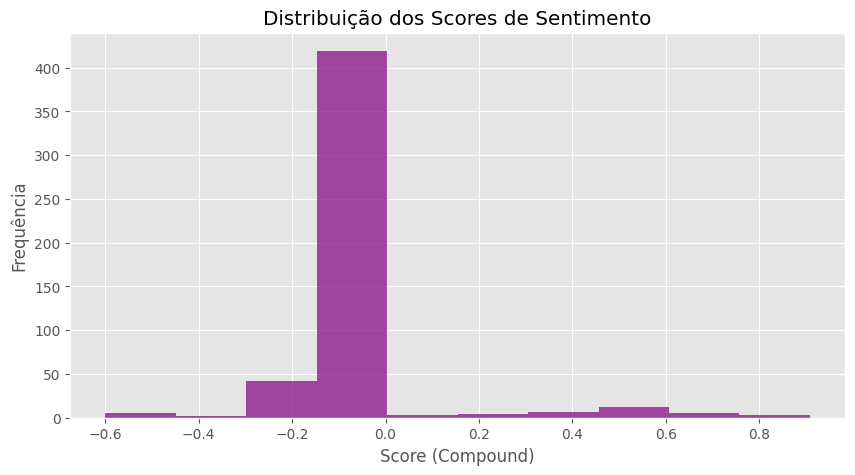


Análise concluída! Verifique os arquivos gerados:
- media_likes_sentimento.png
- distribuicao_sentimentos.png
- relatorio_analise.txt


In [10]:
# Verificar as primeiras linhas
print("\nPrimeiras linhas do DataFrame:")
print(df.head())

# Passo 3: Aplicar VADER
sia = SentimentIntensityAnalyzer()

# Calcular scores de sentimento
df['sentimento_score'] = df['comentario_limpo'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Classificar em categorias (ajuste os thresholds se necessário)
df['sentimento'] = df['sentimento_score'].apply(
    lambda x: 'positivo' if x > 0.05 else ('negativo' if x < -0.05 else 'neutro')
)

# Exibir resultados
print("\nResultados da Análise de Sentimento:")
print(df[['autor', 'comentario_limpo', 'likes', 'sentimento_score', 'sentimento']])

# Passo 4: Análise de Correlação com Likes
media_likes = df.groupby('sentimento')['likes'].mean().reset_index()
print("\nMédia de Likes por Sentimento:")
print(media_likes)

# Visualização 1 - Média de Likes
plt.figure(figsize=(10, 5))
plt.bar(media_likes['sentimento'], media_likes['likes'], color=['red', 'gray', 'green'])
plt.title('Média de Likes por Sentimento')
plt.ylabel('Média de Likes')
plt.savefig('media_likes_sentimento.png')  # Salvar a figura
plt.show()

# Passo 5: Análise Detalhada dos Scores
plt.figure(figsize=(10, 5))
plt.hist(df['sentimento_score'], bins=10, color='purple', alpha=0.7)
plt.title('Distribuição dos Scores de Sentimento')
plt.xlabel('Score (Compound)')
plt.ylabel('Frequência')
plt.savefig('distribuicao_sentimentos.png')  # Salvar a figura
plt.show()

# Passo 6: Análise Adicional (Exemplo com menções)
if 'mencoes_ubisoft' in df.columns:
    ubisoft_engagement = df.groupby('mencoes_ubisoft')['likes'].mean()
    print("\nEngajamento por Menção à Ubisoft:")
    print(ubisoft_engagement)
    

# Geração de Relatório Automático
with open('relatorio_analise.txt', 'w', encoding='utf-8') as f:
    f.write("Relatório de Análise de Sentimento\n")
    f.write("---------------------------------\n")
    f.write(f"Total de comentários analisados: {len(df)}\n")
    f.write(f"Distribuição de sentimentos:\n{df['sentimento'].value_counts().to_string()}\n\n")
    f.write("Recomendações:\n- Priorizar respostas a comentários neutros\n- Reforçar conteúdo com menções positivas à Ubisoft\n- Analisar horários de pico de engajamento")

print("\nAnálise concluída! Verifique os arquivos gerados:")
print("- media_likes_sentimento.png")
print("- distribuicao_sentimentos.png")
print("- relatorio_analise.txt")

2. Detecção de Tópicos com LDA

In [11]:
# Carregar o modelo de língua portuguesa
nlp = spacy.load("pt_core_news_sm")  # Execute antes: python -m spacy download pt_core_news_sm

# Função de pré-processamento
def preprocessamento(texto):
    doc = nlp(texto.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.like_num
        and len(token.lemma_) > 2
    ]
    return tokens

# Aplicar aos dados
df['tokens'] = df['comentario_limpo'].apply(preprocessamento)

# Verificar resultado
print("\nTokens pré-processados:")
print(df[['autor', 'tokens']].head())

# Criar dicionário e corpus
dictionary = corpora.Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=2)  # Remover palavras raras
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Treinar modelo LDA
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,  # Ajuste conforme necessidade
    random_state=42,
    passes=15
)

# Exibir tópicos
print("\nTópicos identificados:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx}: {topic}")


# Atribuir tópico dominante a cada comentário
df['topico_dominante'] = [sorted(lda_model[doc], key=lambda x: x[1], reverse=True)[0][0] for doc in corpus]

# Análise por autor
print("\nDistribuição de tópicos:")
print(df[['autor', 'comentario_limpo', 'topico_dominante']])

# Preparar visualização
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'topicos_vis.html')  # Arquivo interativo

print("\nVisualização salva em 'topicos_vis.html'")


Tokens pré-processados:
                  autor                                            tokens
0         @AlvaroWilian                               [Gold, pedra, Gold]
1                @jetsp               [faye_tan, fazer, cosplay, smzinho]
2           @lucianoxs6                                                []
3  @guilhermedematos767       [descanse, paz, ronaldinho, tao, arrebatar]
4       @thyagojose9589  [sabrinar, carpinteira, complexo, Israel, risar]

Tópicos identificados:
Tópico 0: 0.033*"pastor" + 0.032*"bom" + 0.031*"pra" + 0.026*"broxada" + 0.023*"nao" + 0.018*"podcast" + 0.016*"vida" + 0.015*"voce" + 0.013*"programa" + 0.013*"risar"
Tópico 1: 0.033*"episodio" + 0.031*"foda" + 0.029*"ano" + 0.019*"vcs" + 0.016*"pra" + 0.016*"jogar" + 0.016*"faye" + 0.014*"podcast" + 0.014*"programa" + 0.013*"broxada"
Tópico 2: 0.039*"risar" + 0.036*"nao" + 0.033*"broxar" + 0.032*"magal" + 0.029*"parabem" + 0.027*"ronaldinho" + 0.024*"episodio" + 0.017*"voce" + 0.017*"programa" + 0.01

3. Impacto das mençoes da marca: 


Impacto das Menções à Blizzard:
                       mean  count   sum
mencoes_blizzard                        
False             14.586558    491  7162
True              50.400000     10   504

Diferença percentual: 245.52%


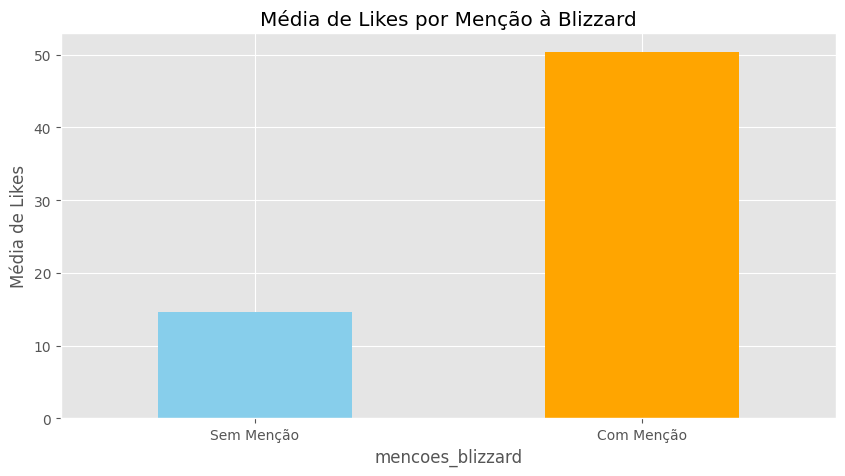


Impacto das Menções à Nome do Jogo:
                   mean  count   sum
mencoes_jogo                        
False         15.676955    486  7619
True           3.133333     15    47

Diferença percentual: -80.01%


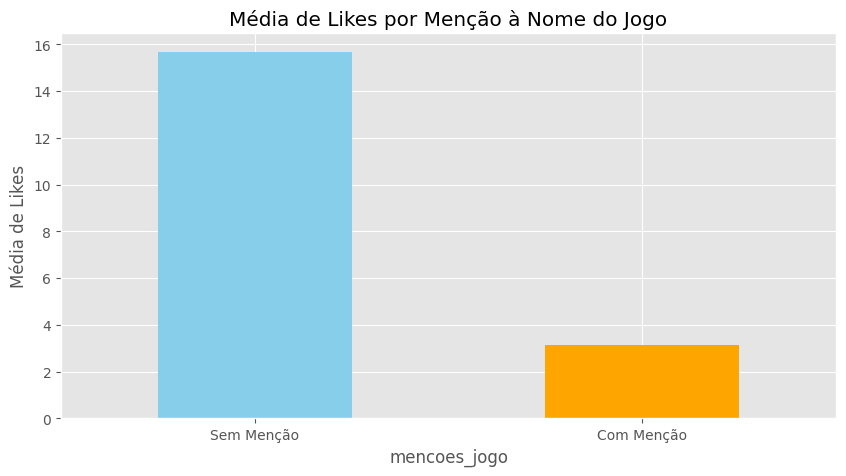

[False  True]


NameError: name 'analise_temporal' is not defined

In [12]:
# Análise de Engajamento
def analisar_impacto_mencoes(coluna_mencao, nome_marca):
    engajamento = df.groupby(coluna_mencao)['likes'].agg(['mean', 'count', 'sum'])
    
    print(f"\nImpacto das Menções à {nome_marca}:")
    print(engajamento)
    
    # Teste estatístico simplificado
    if engajamento.shape[0] > 1:
        diff = engajamento['mean'].diff().iloc[-1]
        print(f"\nDiferença percentual: {diff/engajamento['mean'].iloc[0]*100:.2f}%")
    
    # Visualização
    plt.figure(figsize=(10, 5))
    engajamento['mean'].plot(kind='bar', color=['skyblue', 'orange'])
    plt.title(f'Média de Likes por Menção à {nome_marca}')
    plt.xticks([0, 1], ['Sem Menção', 'Com Menção'], rotation=0)
    plt.ylabel('Média de Likes')
    plt.show()

engajamento = analisar_impacto_mencoes('mencoes_blizzard', 'Blizzard')
engajamento = analisar_impacto_mencoes('mencoes_jogo', 'Nome do Jogo')

print(df['mencoes_blizzard'].unique())

df.loc[0, 'mencoes_blizzard'] = True
analise_temporal('mencoes_blizzard')

print(df['mencoes_blizzard'].value_counts())

4. Análise Temporal


In [13]:
# Convertendo a coluna 'hora' para datetime
df['hora'] = pd.to_datetime(df['hora'])

# Criando uma coluna com a hora do dia
df['hora_completa'] = df['hora'].dt.hour

In [14]:
# Função de Análise Temporal para Menções
def analise_temporal(coluna_mencao):
    # Filtrando os dados pela coluna de menção (True ou False)
    temporal = df[df[coluna_mencao]].groupby('hora_completa')['likes'].mean()
    
    # Verificando se existem dados para a coluna escolhida
    if temporal.empty:
        print(f"Não há dados para a coluna {coluna_mencao}")
        return

    # Plotando a distribuição temporal
    plt.figure(figsize=(10, 5))
    temporal.plot(kind='line', marker='o')
    plt.title(f'Distribuição Temporal das Menções ({coluna_mencao})')
    plt.xlabel('Hora do Dia')
    plt.ylabel('Média de Likes')
    plt.grid(True)

    # Salvando o gráfico como imagem
    plt.tight_layout()
    plt.savefig(f"grafico_temporal_{coluna_mencao}.png")
    print(f"Gráfico salvo como 'grafico_temporal_{coluna_mencao}.png'")

    # Exibindo o gráfico
    plt.show()



4. Análise Temporal de Engajamento

/tmp/ipykernel_7349/4096597861.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hora', y='Total_Likes', data=engagement_hora, palette='viridis')
/tmp/ipykernel_7349/4096597861.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hora_completa', data=df, palette='coolwarm')


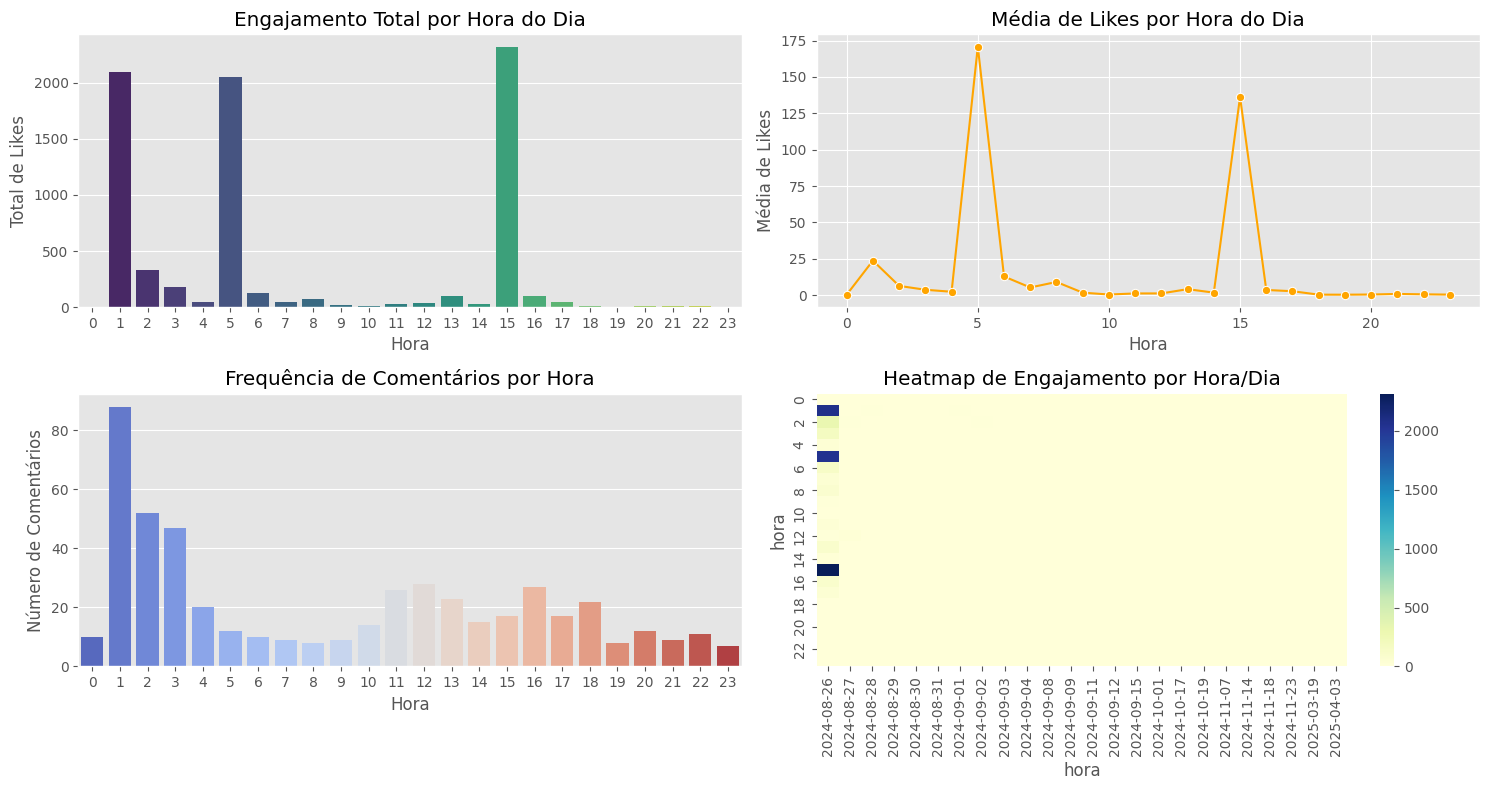

In [25]:
# Passo 1: Converter para datetime e extrair componentes temporais
df['hora'] = pd.to_datetime(df['hora'])
df['hora_completa'] = df['hora'].dt.hour
df['dia_da_semana'] = df['hora'].dt.day_name(locale='pt_BR')  # Requer instalacao: pip install tzdata

# Passo 2: Agregar dados por hora
engagement_hora = df.groupby('hora_completa').agg({
    'likes': ['sum', 'mean', 'count'],
    'autor': 'count'
}).reset_index()
engagement_hora.columns = ['Hora', 'Total_Likes', 'Media_Likes', 'Qtd_Comentarios', 'Total_Comentarios']

# Passo 3: Visualização detalhada
plt.figure(figsize=(15, 8))

# Subplot 1: Total de Likes por Hora
plt.subplot(2, 2, 1)
sns.barplot(x='Hora', y='Total_Likes', data=engagement_hora, palette='viridis')
plt.title('Engajamento Total por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Total de Likes')

# Subplot 2: Média de Likes por Hora
plt.subplot(2, 2, 2)
sns.lineplot(x='Hora', y='Media_Likes', data=engagement_hora, marker='o', color='orange')
plt.title('Média de Likes por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Média de Likes')

# Subplot 3: Quantidade de Comentários por Hora
plt.subplot(2, 2, 3)
sns.countplot(x='hora_completa', data=df, palette='coolwarm')
plt.title('Frequência de Comentários por Hora')
plt.xlabel('Hora')
plt.ylabel('Número de Comentários')

# Subplot 4: Heatmap de Engajamento (exemplo para múltiplos dias)
plt.subplot(2, 2, 4)
if df['hora'].dt.date.nunique() > 1:  # Só plotar se houver múltiplos dias
    pivot_table = df.pivot_table(
        index=df['hora'].dt.hour,
        columns=df['hora'].dt.date,
        values='likes',
        aggfunc='sum',
        fill_value=0
    )
    sns.heatmap(pivot_table, cmap='YlGnBu')
    plt.title('Heatmap de Engajamento por Hora/Dia')
else:
    plt.text(0.3, 0.5, 'Dados insuficientes para heatmap\n(múltiplos dias requeridos)', 
             fontsize=12, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
# Passo 4: Análise do Melhor Horário
melhor_hora = engagement_hora.loc[engagement_hora['Total_Likes'].idxmax()]
print(f"\nMelhor horário para engajamento: {melhor_hora['Hora']}h")
print(f"Total de likes nesse horário: {melhor_hora['Total_Likes']}")
print(f"Média de likes: {melhor_hora['Media_Likes']:.2f}")
print(f"Comentários registrados: {melhor_hora['Qtd_Comentarios']}")

# Passo 5: Análise Estatística por Hora
print("\nResumo Estatístico por Hora:")
print(engagement_hora.describe().transpose())


Melhor horário para engajamento: 15.0h
Total de likes nesse horário: 2316.0
Média de likes: 136.24
Comentários registrados: 17.0

Resumo Estatístico por Hora:
                   count        mean         std    min       25%   50%  \
Hora                24.0   11.500000    7.071068  0.000  5.750000  11.5   
Total_Likes         24.0  319.416667  712.999903  3.000  7.750000  41.0   
Media_Likes         24.0   16.312201   42.877537  0.375  0.602273   2.1   
Qtd_Comentarios     24.0   20.875000   18.449255  7.000  9.750000  14.5   
Total_Comentarios   24.0   20.791667   18.218431  7.000  9.750000  14.5   

                          75%      max  
Hora                17.250000    23.00  
Total_Likes        105.750000  2316.00  
Media_Likes          5.605769   170.75  
Qtd_Comentarios     23.750000    88.00  
Total_Comentarios   23.750000    87.00  


5. Análise de Humor e Engajamento

                    autor  contem_risada
0           @AlvaroWilian          False
1                  @jetsp          False
2             @lucianoxs6          False
3    @guilhermedematos767          False
4         @thyagojose9589           True
..                    ...            ...
496       @mateusmello759          False
497              @thalesl          False
498            @Rafael_33          False
499              @zexs918          False
500       @wesleyaxel7656          False

[501 rows x 2 columns]


/tmp/ipykernel_7349/3127260668.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grupo_risada, grupo_sem_risada], labels=['Com Risada', 'Sem Risada'])


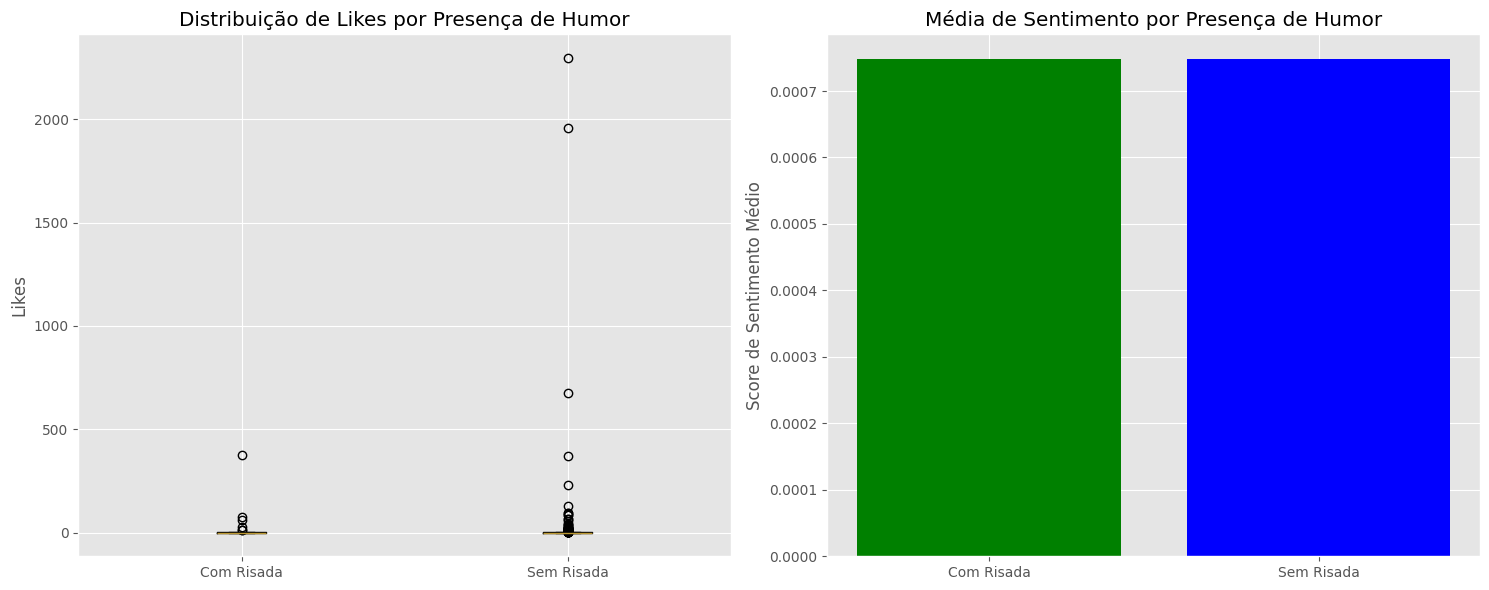

In [ ]:
# Função para detectar risadas automaticamente (caso a coluna original esteja incompleta)
def detectar_risada(texto):
    keywords = ['risada', 'kkk', 'haha', 'rsrs']
    return any(kw in texto.lower() for kw in keywords)

# Aplicar detecção automática se necessário
df['risada_auto'] = df['comentario_limpo'].apply(detectar_risada)

# Análise comparativa
engajamento_risada = df.groupby('contem_risada')['likes'].agg(['mean', 'median', 'std', 'count'])
engajamento_sentimento = df.groupby('contem_risada')['sentimento_score'].mean()

# Versão corrigida do código (remove grupos de captura desnecessários)
df['contem_risada'] = df['comentario_limpo'].str.contains(
    r'\b(?:risada|k{3,}|haha|rs+)\b',  # <-- Note o '?:' para grupos não-capturadores
    case=False,
    regex=True
)

# Resultado corrigido:
print(df[['autor', 'contem_risada']])

# Teste estatístico (Mann-Whitney para amostras não normais)
grupo_risada = df[df['contem_risada']]['likes']
grupo_sem_risada = df[~df['contem_risada']]['likes']
stat, p_value = stats.mannwhitneyu(grupo_risada, grupo_sem_risada)

# Visualização
plt.figure(figsize=(15, 6))

# Gráfico 1: Distribuição de Likes
plt.subplot(1, 2, 1)
plt.boxplot([grupo_risada, grupo_sem_risada], labels=['Com Risada', 'Sem Risada'])
plt.title('Distribuição de Likes por Presença de Humor')
plt.ylabel('Likes')

# Gráfico 2: Sentimento vs Risada
plt.subplot(1, 2, 2)
plt.bar(['Com Risada', 'Sem Risada'], engajamento_sentimento, color=['green', 'blue'])
plt.title('Média de Sentimento por Presença de Humor')
plt.ylabel('Score de Sentimento Médio')

plt.tight_layout()
plt.show()

In [3]:
caminho_csv = pd.read_csv('/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv') # Leitura do CSV
caminho_csv

,autor,comentario,likes,hora,comentario_limpo,mencoes_blizzard,mencoes_jogo,contem_risada
0,@AlvaroWilian,51:30 GOLD. PEDRA DE GOLD,0,2025-04-03 02:22:50,51 30 gold pedra de gold,False,False,False
1,@jetsp,"Faye_tan, fazendo cosplay de smzinho?",0,2025-03-19 14:38:34,faye_tan fazendo cosplay de smzinho,False,False,False
2,@lucianoxs6,2:01:01,0,2024-11-23 16:07:29,2 01 01,False,False,False
3,@guilhermedematos767,"descanse em paz ronaldinho, tao novo e já foi ...",0,2024-11-18 20:55:31,descanse em paz ronaldinho tao novo e ja foi a...,False,False,False
4,@thyagojose9589,Sabrina Carpinteira do complexo de Israel kkkk...,0,2024-11-14 15:43:50,sabrina carpinteira do complexo de israel risada,False,False,False
...,...,...,...,...,...,...,...,...
496,@mateusmello759,Um episódio épico com o elenco da série Hércules,0,2024-08-26 01:42:44,um episodio epico com o elenco da serie hercules,False,False,False
497,@thalesl,first,0,2024-08-26 01:42:43,first,False,False,False
498,@Rafael_33,O que o sapo da boca grande fez hoje não se es...,1,2024-08-26 01:42:43,o que o sapo da boca grande fez hoje nao se es...,False,False,False
499,@zexs918,EPISÓDIO INCRIVEL,0,2024-08-26 01:42:42,episodio incrivel,False,False,False


Lista das Palavras Positivas

Total de comentários: 501
Total positivos: 119
Percentual positivo: 23.75%
Top palavras positivas: {'muito': 42, 'foda': 24, 'bom': 24, 'melhor': 23, 'melhores': 11, 'incrível': 9, 'mt': 5, 'humor': 5, 'incrivel': 4, 'perfeito': 3, 'top': 3, 'maravilhoso': 2, 'divertido': 2, 'excelente': 1, 'fenômeno': 1, 'fantástico': 1, 'recomendo': 1, 'impressionante': 1}


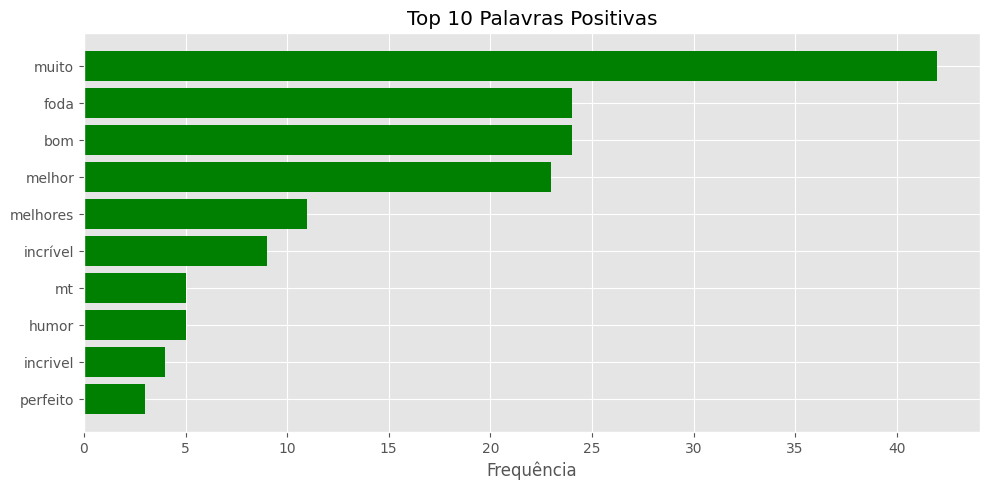

In [16]:
import re
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

# Lista de palavras positivas
PALAVRAS_POSITIVAS = {
    "incrível", "ótimo", "maravilhoso", "excelente", "adorei", 
    "recomendo", "fantástico", "perfeito", "impressionante", 
    "sensacional", "mt", "muito", "bom", "foda",
    "incrivel", "divertido", "top", "fenômeno", "humor",
    "melhor", "melhores"
}

def analisar_sentimentos_positivos(caminho_arquivo, coluna_comentario="comentario"):
    contador_palavras = defaultdict(int)
    comentarios_positivos = []
    total_comentarios = 0
    total_positivos = 0

    # Regex simples para detectar palavras
    regex_positivas = [re.compile(rf"\b{re.escape(p)}\b", re.IGNORECASE) for p in PALAVRAS_POSITIVAS]

    with open(caminho_arquivo, mode='r', encoding='utf-8') as arquivo:
        leitor = csv.DictReader(arquivo)

        for linha in leitor:
            total_comentarios += 1
            comentario = linha[coluna_comentario].lower()
            palavras_encontradas = set()

            for regex in regex_positivas:
                if regex.search(comentario):
                    palavra = regex.pattern.replace(r"\b", "").strip("\\").lower()
                    palavras_encontradas.add(palavra)

            if palavras_encontradas:
                total_positivos += 1
                comentarios_positivos.append({
                    "texto": linha[coluna_comentario],
                    "palavras_chave": list(palavras_encontradas)
                })
                for palavra in palavras_encontradas:
                    contador_palavras[palavra] += 1

    return {
        "total_comentarios": total_comentarios,
        "total_positivos": total_positivos,
        "percentual_positivo": (total_positivos / total_comentarios * 100) if total_comentarios > 0 else 0,
        "palavras_chave_detectadas": dict(sorted(contador_palavras.items(), key=lambda x: x[1], reverse=True)),
        "comentarios_positivos": comentarios_positivos
    }

# Chamada da função
caminho = "/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv"
resultados = analisar_sentimentos_positivos(caminho)

# Impressão de resultados
print(f"Total de comentários: {resultados['total_comentarios']}")
print(f"Total positivos: {resultados['total_positivos']}")
print(f"Percentual positivo: {resultados['percentual_positivo']:.2f}%")
print("Top palavras positivas:", resultados['palavras_chave_detectadas'])

# Visualização das top palavras positivas
palavras = list(resultados['palavras_chave_detectadas'].keys())[:10]
frequencias = list(resultados['palavras_chave_detectadas'].values())[:10]

plt.figure(figsize=(10, 5))
plt.barh(palavras[::-1], frequencias[::-1], color='green')
plt.xlabel("Frequência")
plt.title("Top 10 Palavras Positivas")
plt.tight_layout()
plt.show()


Total de comentários: 501
Total positivos: 112
Percentual positivo: 22.36%
Top palavras positivas: {'parabéns': 26, 'foda': 24, 'amo': 12, 'incrível': 9, 'parabens': 8, 'demais': 5, 'incrivel': 4, 'gostei': 4, 'perfeito': 3, 'mto': 3, 'top': 3, 'maneiro': 2, 'amei': 2, 'maravilhoso': 2, 'massa': 2, 'sensação': 2, 'genial': 2, 'único': 2, 'excelente': 1, 'excepcional': 1, 'sinistro': 1, 'br': 1, 'fantástico': 1, 'animal': 1, 'irado': 1, 'fod': 1, 'brabo': 1, 'firme': 1, 'mto\\ bom': 1, 'arrasou': 1, 'adoro': 1, 'recomendo': 1, 'dms': 1, 'impressionante': 1, 'impecavel': 1}


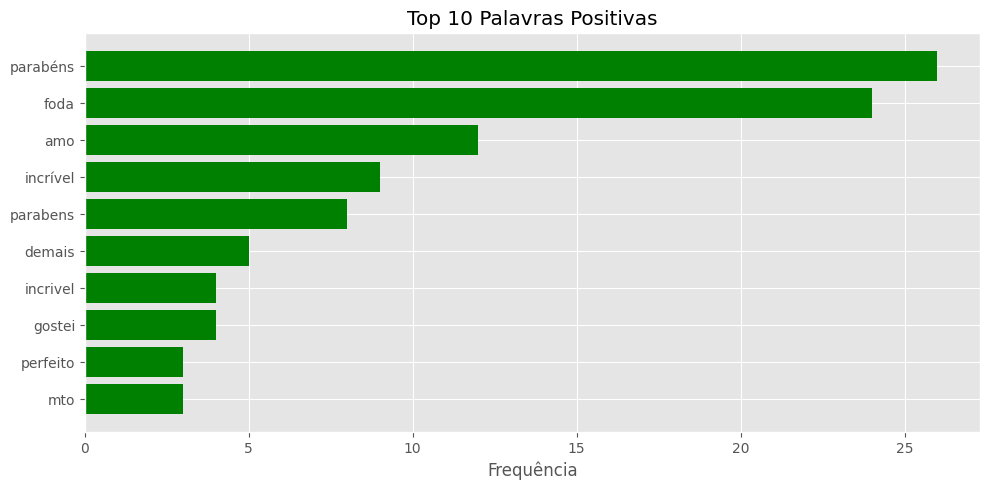

In [5]:
import re
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

# Lista de palavras positivas
PALAVRAS_POSITIVAS = {
    # Adjetivos (com/sem acentos e abreviações)
    "incrível", "incrivel", "ótimo", "otimo", "maravilhoso", "excelente", "excel", 
    "fantástico", "fantastico", "perfeito", "impressionante", "sensacional", "sensac", 
    "espetacular", "notável", "notavel", "formidável", "formidavel", "excepcional", 
    "brilhante", "br", "fenomenal", "surpreendente", "surpreend", "único", "unico", 
    "extraordinário", "extraordinario", "magnífico", "magnifico", "estupendo", 
    "genial", "incomparável", "incomparavel", "impecável", "impecavel", "agradável", 
    "agradavel", "eficiente", "eficaz", "superior", "sup", "incrivelmente bom", 
    "divino", "encantador", "inspirador", "revolucionário", "revolucionario", 
    "exuberante", "radiante", "aproveitoso", "competente", "comp",

    # Expressões verbais e interjeições (abreviadas)
    "adorei", "adoro", "amei", "amo", "recomendo", "reco", "aprovado", "aprov", 
    "aprovei", "gostei", "gostei mto", "valeu a pena", "vlw a pena", "funciona", 
    "func", "surpreendeu", "superou expectativas", "sup expect", "parabéns", "parabens", 
    "pb", "top", "top d+", "show", "shoow", "demais", "d+", "irado", "sensação", 
    "sensac", "nota 10", "n10", "mandou bem", "mando bem", "arrasou", "chocou", 
    "fez diferença", "fez diff",

    # Termos coloquiais (gírias e variações)
    "maneiro", "manero", "da hora", "dhr", "massa", "mssa", "foda", "fod", 
    "brabo", "brabo d+", "topzera", "firme", "firmeza", "animal", "anim", 
    "sinistro", "sinistro", "cabuloso", "cabrobr", "zica", "supimpa", "maravilindo", 
    "arretado", "arret",

    # Contextos específicos (abreviações)
    "econômico", "economico", "durável", "durave", "prático", "pratico", "rápido", 
    "rapido", "confiável", "confiavel", "moderno", "mod", "inovador", "customizável", 
    "customizavel", "intuitivo", "potente", "pot", "estiloso", "estilo", "confortável", 
    "confortavel", "sofisticado", "sofisti", "vibrante", "harmonioso",

    # Abreviações comuns na internet
    "mt bom", "mt bom", "mto bom", "top dms", "dms", "mto", "show d+", "incrivel d+"
}

def analisar_sentimentos_positivos(caminho_arquivo, coluna_comentario="comentario"):
    contador_palavras = defaultdict(int)
    comentarios_positivos = []
    total_comentarios = 0
    total_positivos = 0

    # Regex simples para detectar palavras
    regex_positivas = [re.compile(rf"\b{re.escape(p)}\b", re.IGNORECASE) for p in PALAVRAS_POSITIVAS]

    with open(caminho_arquivo, mode='r', encoding='utf-8') as arquivo:
        leitor = csv.DictReader(arquivo)

        for linha in leitor:
            total_comentarios += 1
            comentario = linha[coluna_comentario].lower()
            palavras_encontradas = set()

            for regex in regex_positivas:
                if regex.search(comentario):
                    palavra = regex.pattern.replace(r"\b", "").strip("\\").lower()
                    palavras_encontradas.add(palavra)

            if palavras_encontradas:
                total_positivos += 1
                comentarios_positivos.append({
                    "texto": linha[coluna_comentario],
                    "palavras_chave": list(palavras_encontradas)
                })
                for palavra in palavras_encontradas:
                    contador_palavras[palavra] += 1

    return {
        "total_comentarios": total_comentarios,
        "total_positivos": total_positivos,
        "percentual_positivo": (total_positivos / total_comentarios * 100) if total_comentarios > 0 else 0,
        "palavras_chave_detectadas": dict(sorted(contador_palavras.items(), key=lambda x: x[1], reverse=True)),
        "comentarios_positivos": comentarios_positivos
    }

# Chamada da função
caminho = "/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv"
resultados = analisar_sentimentos_positivos(caminho)

# Impressão de resultados
print(f"Total de comentários: {resultados['total_comentarios']}")
print(f"Total positivos: {resultados['total_positivos']}")
print(f"Percentual positivo: {resultados['percentual_positivo']:.2f}%")
print("Top palavras positivas:", resultados['palavras_chave_detectadas'])

# Visualização das top palavras positivas
palavras = list(resultados['palavras_chave_detectadas'].keys())[:10]
frequencias = list(resultados['palavras_chave_detectadas'].values())[:10]

plt.figure(figsize=(10, 5))
plt.barh(palavras[::-1], frequencias[::-1], color='green')
plt.xlabel("Frequência")
plt.title("Top 10 Palavras Positivas")
plt.tight_layout()
plt.show()


Total de comentários: 501
Com palavras maiúsculas positivas: 14
Percentual: 2.79%
Top palavras maiúsculas positivas: {'AMO': 5, 'PARABÉNS': 4, 'INCRIVEL': 2, 'PARABENS': 2, 'TOP': 1, 'GOSTEI': 1, 'MTO': 1, 'IMPECAVEL': 1, 'FODA': 1}


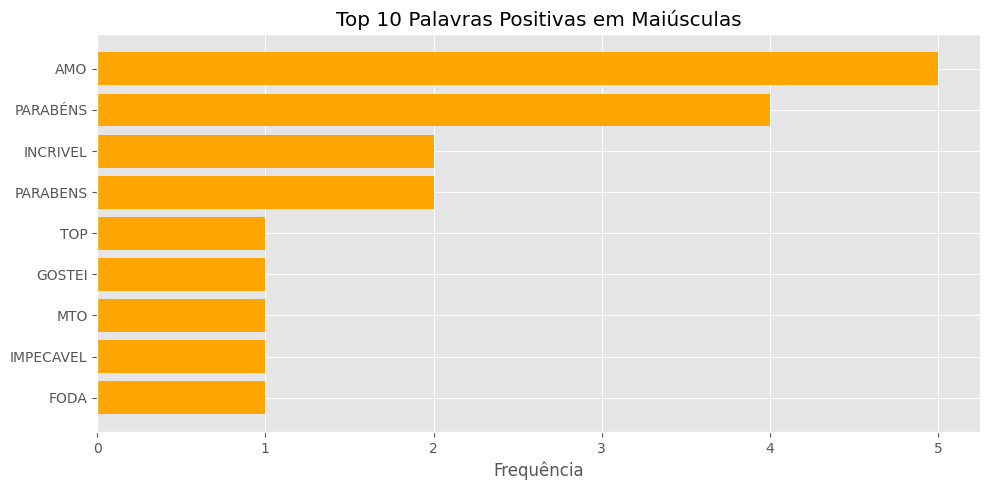

In [10]:
import csv
import re
from collections import defaultdict

# Lista de palavras positivas conhecidas
PALAVRAS_POSITIVAS = {
    # Adjetivos (com/sem acentos e abreviações)
    "incrível", "incrivel", "ótimo", "otimo", "maravilhoso", "excelente", "excel", 
    "fantástico", "fantastico", "perfeito", "impressionante", "sensacional", "sensac", 
    "espetacular", "notável", "notavel", "formidável", "formidavel", "excepcional", 
    "brilhante", "br", "fenomenal", "surpreendente", "surpreend", "único", "unico", 
    "extraordinário", "extraordinario", "magnífico", "magnifico", "estupendo", 
    "genial", "incomparável", "incomparavel", "impecável", "impecavel", "agradável", 
    "agradavel", "eficiente", "eficaz", "superior", "sup", "incrivelmente bom", 
    "divino", "encantador", "inspirador", "revolucionário", "revolucionario", 
    "exuberante", "radiante", "aproveitoso", "competente", "comp",

    # Expressões verbais e interjeições (abreviadas)
    "adorei", "adoro", "amei", "amo", "recomendo", "reco", "aprovado", "aprov", 
    "aprovei", "gostei", "gostei mto", "valeu a pena", "vlw a pena", "funciona", 
    "func", "surpreendeu", "superou expectativas", "sup expect", "parabéns", "parabens", 
    "pb", "top", "top d+", "show", "shoow", "demais", "d+", "irado", "sensação", 
    "sensac", "nota 10", "n10", "mandou bem", "mando bem", "arrasou", "chocou", 
    "fez diferença", "fez diff",

    # Termos coloquiais (gírias e variações)
    "maneiro", "manero", "da hora", "dhr", "massa", "mssa", "foda", "fod", 
    "brabo", "brabo d+", "topzera", "firme", "firmeza", "animal", "anim", 
    "sinistro", "sinistro", "cabuloso", "cabrobr", "zica", "supimpa", "maravilindo", 
    "arretado", "arret",

    # Contextos específicos (abreviações)
    "econômico", "economico", "durável", "durave", "prático", "pratico", "rápido", 
    "rapido", "confiável", "confiavel", "moderno", "mod", "inovador", "customizável", 
    "customizavel", "intuitivo", "potente", "pot", "estiloso", "estilo", "confortável", 
    "confortavel", "sofisticado", "sofisti", "vibrante", "harmonioso",

    # Abreviações comuns na internet
    "mt bom", "mt bom", "mto bom", "top dms", "dms", "mto", "show d+", "incrivel d+"
}

def analisar_maiusculas_positivas(caminho_csv, coluna_comentario="comentario"):
    contador_palavras = defaultdict(int)
    comentarios_com_maiusculas = []
    total_comentarios = 0
    total_detectados = 0

    with open(caminho_csv, mode='r', encoding='utf-8') as arquivo:
        leitor = csv.DictReader(arquivo)
        
        for linha in leitor:
            total_comentarios += 1
            comentario = linha[coluna_comentario]
            palavras_maiusculas = re.findall(r'\b[A-ZÀ-Ú]{2,}\b', comentario)

            palavras_detectadas = [
                palavra for palavra in palavras_maiusculas
                if palavra.lower() in PALAVRAS_POSITIVAS
            ]

            if palavras_detectadas:
                total_detectados += 1
                comentarios_com_maiusculas.append({
                    "texto": comentario,
                    "palavras_maiusculas_positivas": palavras_detectadas
                })
                for palavra in palavras_detectadas:
                    contador_palavras[palavra] += 1

    return {
        "total_comentarios": total_comentarios,
        "total_detectados": total_detectados,
        "percentual_detectado": (total_detectados / total_comentarios * 100) if total_comentarios > 0 else 0,
        "palavras_maiusculas_positivas": dict(sorted(contador_palavras.items(), key=lambda x: x[1], reverse=True)),
        "comentarios_detectados": comentarios_com_maiusculas
    }

caminho = "/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv"
resultado_maiusculas = analisar_maiusculas_positivas(caminho)

print(f"Total de comentários: {resultado_maiusculas['total_comentarios']}")
print(f"Com palavras maiúsculas positivas: {resultado_maiusculas['total_detectados']}")
print(f"Percentual: {resultado_maiusculas['percentual_detectado']:.2f}%")
print("Top palavras maiúsculas positivas:", resultado_maiusculas['palavras_maiusculas_positivas'])

import matplotlib.pyplot as plt

# Extraindo as top palavras
palavras = list(resultado_maiusculas['palavras_maiusculas_positivas'].keys())[:10]
frequencias = list(resultado_maiusculas['palavras_maiusculas_positivas'].values())[:10]

# Criar o gráfico
plt.figure(figsize=(10, 5))
plt.barh(palavras[::-1], frequencias[::-1], color='orange')
plt.xlabel("Frequência")
plt.title("Top 10 Palavras Positivas em Maiúsculas")
plt.tight_layout()
plt.show()


/tmp/ipykernel_6861/3852082247.py:49: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6861/3852082247.py:49: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6861/3852082247.py:49: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/boto-cdr/anaconda3/envs/bio_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/boto-cdr/anaconda3/envs/bio_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/boto-cdr/anaconda3/envs/bio_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) miss

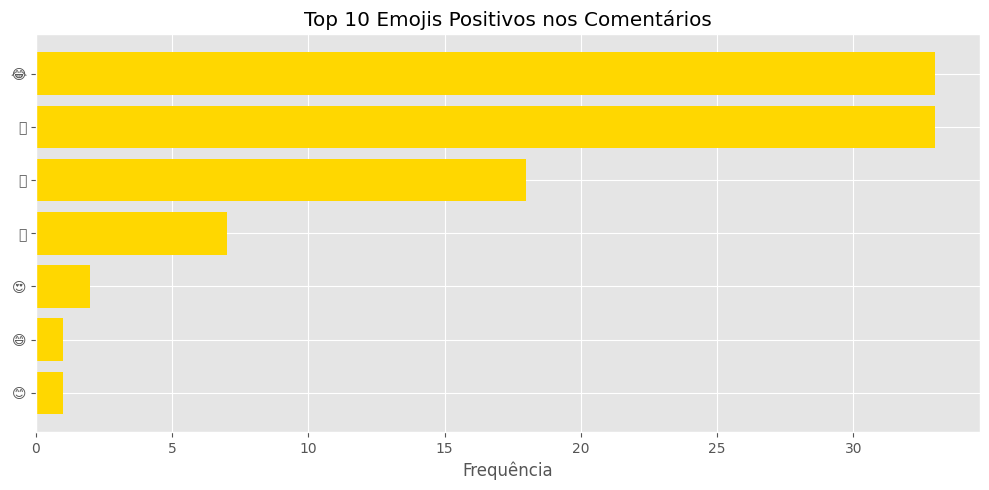

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. Carregar os comentários
df = pd.read_csv("/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv") # ajuste o caminho se necessário

# 2. Lista de emojis positivos
EMOJIS_POSITIVOS = {
    "😄", "😃", "😀", "😊", "😍", "🤩", "😂", "🤣", "👏", "👍",
    "💖", "🔥", "💯", "🙌", "😁", "🥰", "😎", "🎉", "✨", "😆"
}

# 3. Função para detectar emojis positivos
def detectar_emojis_positivos(lista_comentarios):
    comentarios_com_emojis = []
    contador_emojis = defaultdict(int)

    for comentario in lista_comentarios:
        encontrados = [char for char in comentario if char in EMOJIS_POSITIVOS]
        if encontrados:
            comentarios_com_emojis.append({
                "texto": comentario,
                "emojis": encontrados
            })
            for emoji_encontrado in encontrados:
                contador_emojis[emoji_encontrado] += 1

    return {
        "total_comentarios": len(lista_comentarios),
        "total_com_emojis": len(comentarios_com_emojis),
        "percentual_com_emojis": (len(comentarios_com_emojis) / len(lista_comentarios) * 100) if lista_comentarios else 0,
        "emojis_detectados": dict(sorted(contador_emojis.items(), key=lambda x: x[1], reverse=True)),
        "comentarios_com_emojis": comentarios_com_emojis
    }

# 4. Executar análise
comentarios = df["comentario"].astype(str).tolist()  # garante que tudo é string
resultado_emojis = detectar_emojis_positivos(comentarios)

# 5. Visualizar top 10 emojis
emojis = list(resultado_emojis['emojis_detectados'].keys())[:10]
frequencias = list(resultado_emojis['emojis_detectados'].values())[:10]

plt.figure(figsize=(10, 5))
plt.barh(emojis[::-1], frequencias[::-1], color='gold')
plt.xlabel("Frequência")
plt.title("Top 10 Emojis Positivos nos Comentários")
plt.tight_layout()
plt.show()


Total de comentários: 501
Total positivos: 231
Percentual positivo: 46.11%
Top palavras e emojis positivos: {'br': 128, 'fod': 31, 'foda': 29, 'amo': 28, 'parabéns': 26, 'comp': 19, '🔥': 14, '😂': 11, '🎉': 11, 'incrível': 9, 'parabens': 8, 'pot': 7, 'reco': 6, 'sup': 5, 'demais': 5, 'incrivel': 4, 'gostei': 4, 'perfeito': 3, 'mto': 3, 'top': 3, 'único': 3, '👏': 3, '😍': 2, 'maneiro': 2, 'brabo': 2, 'amei': 2, 'maravilhoso': 2, 'sinistro': 2, 'massa': 2, 'sensação': 2, 'genial': 2, 'anim': 2, 'excelente': 1, 'excel': 1, 'mod': 1, 'excepcional': 1, 'fantástico': 1, 'animal': 1, 'irado': 1, 'firme': 1, '😄': 1, 'mto bom': 1, 'arrasou': 1, 'adoro': 1, '😊': 1, 'recomendo': 1, 'dms': 1, 'impressionante': 1, 'sensac': 1, 'impecavel': 1}


/tmp/ipykernel_6861/3988010119.py:110: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6861/3988010119.py:110: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


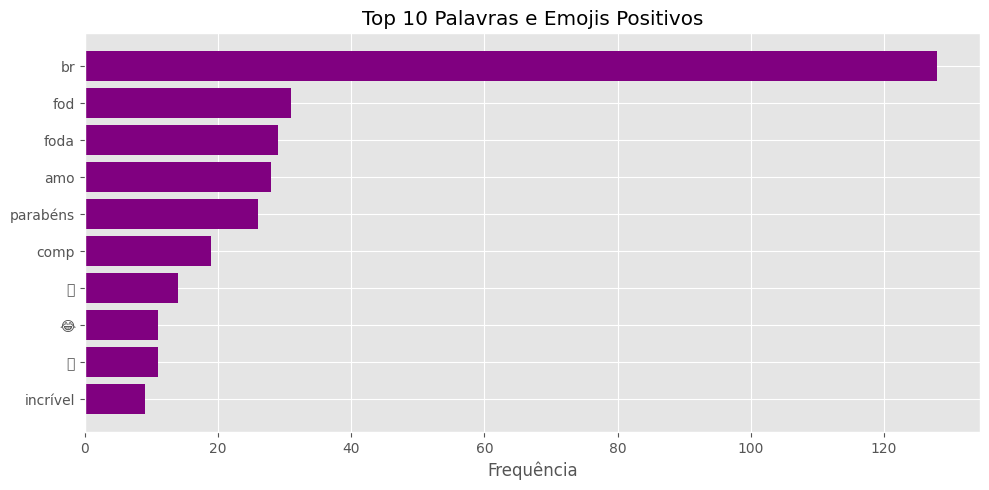

In [14]:
import csv
import re
from collections import defaultdict

# Lista de palavras positivas conhecidas (sem mudanças)
PALAVRAS_POSITIVAS = {
    "incrível", "incrivel", "ótimo", "otimo", "maravilhoso", "excelente", "excel", 
    "fantástico", "fantastico", "perfeito", "impressionante", "sensacional", "sensac", 
    "espetacular", "notável", "notavel", "formidável", "formidavel", "excepcional", 
    "brilhante", "br", "fenomenal", "surpreendente", "surpreend", "único", "unico", 
    "extraordinário", "extraordinario", "magnífico", "magnifico", "estupendo", 
    "genial", "incomparável", "incomparavel", "impecável", "impecavel", "agradável", 
    "agradavel", "eficiente", "eficaz", "superior", "sup", "incrivelmente bom", 
    "divino", "encantador", "inspirador", "revolucionário", "revolucionario", 
    "exuberante", "radiante", "aproveitoso", "competente", "comp",
    "adorei", "adoro", "amei", "amo", "recomendo", "reco", "aprovado", "aprov", 
    "aprovei", "gostei", "gostei mto", "valeu a pena", "vlw a pena", "funciona", 
    "func", "surpreendeu", "superou expectativas", "sup expect", "parabéns", "parabens", 
    "pb", "top", "top d+", "show", "shoow", "demais", "d+", "irado", "sensação", 
    "sensac", "nota 10", "n10", "mandou bem", "mando bem", "arrasou", "chocou", 
    "fez diferença", "fez diff",
    "maneiro", "manero", "da hora", "dhr", "massa", "mssa", "foda", "fod", 
    "brabo", "brabo d+", "topzera", "firme", "firmeza", "animal", "anim", 
    "sinistro", "sinistro", "cabuloso", "cabrobr", "zica", "supimpa", "maravilindo", 
    "arretado", "arret",
    "econômico", "economico", "durável", "durave", "prático", "pratico", "rápido", 
    "rapido", "confiável", "confiavel", "moderno", "mod", "inovador", "customizável", 
    "customizavel", "intuitivo", "potente", "pot", "estiloso", "estilo", "confortável", 
    "confortavel", "sofisticado", "sofisti", "vibrante", "harmonioso",
    "mt bom", "mt bom", "mto bom", "top dms", "dms", "mto", "show d+", "incrivel d+"
}

# Lista de emojis positivos
EMOJIS_POSITIVOS = {
    "😄", "😃", "😀", "😊", "😍", "🤩", "😂", "🤣", "👏", "👍",
    "💖", "🔥", "💯", "🙌", "😁", "🥰", "😎", "🎉", "✨", "😆"
}

def analisar_sentimentos(caminho_csv, coluna_comentario="comentario"):
    contador_palavras = defaultdict(int)
    comentarios_positivos = []
    total_comentarios = 0
    total_positivos = 0

    with open(caminho_csv, mode='r', encoding='utf-8') as arquivo:
        leitor = csv.DictReader(arquivo)

        for linha in leitor:
            total_comentarios += 1
            comentario = linha[coluna_comentario]
            palavras_encontradas = set()

            # Detecção de palavras minúsculas positivas
            comentario_lower = comentario.lower()
            for palavra in PALAVRAS_POSITIVAS:
                if palavra in comentario_lower:
                    palavras_encontradas.add(palavra)

            # Detecção de palavras maiúsculas positivas
            palavras_maiusculas = re.findall(r'\b[A-ZÀ-Ú]{2,}\b', comentario)
            for palavra in palavras_maiusculas:
                if palavra.lower() in PALAVRAS_POSITIVAS:
                    palavras_encontradas.add(palavra.lower())

            # Detecção de emojis positivos
            emojis = re.findall(r'[^\w\s,]', comentario)  # Captura emojis e outros símbolos não alfanuméricos
            for emoji in emojis:
                if emoji in EMOJIS_POSITIVOS:
                    palavras_encontradas.add(emoji)

            if palavras_encontradas:
                total_positivos += 1
                comentarios_positivos.append({
                    "texto": comentario,
                    "palavras_chave": list(palavras_encontradas)
                })
                for palavra in palavras_encontradas:
                    contador_palavras[palavra] += 1

    return {
        "total_comentarios": total_comentarios,
        "total_positivos": total_positivos,
        "percentual_positivo": (total_positivos / total_comentarios * 100) if total_comentarios > 0 else 0,
        "palavras_chave_detectadas": dict(sorted(contador_palavras.items(), key=lambda x: x[1], reverse=True)),
        "comentarios_positivos": comentarios_positivos
    }

# Caminho do CSV
caminho = "/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv"
resultado_combinado = analisar_sentimentos(caminho)

# Exibição dos resultados
print(f"Total de comentários: {resultado_combinado['total_comentarios']}")
print(f"Total positivos: {resultado_combinado['total_positivos']}")
print(f"Percentual positivo: {resultado_combinado['percentual_positivo']:.2f}%")
print("Top palavras e emojis positivos:", resultado_combinado['palavras_chave_detectadas'])

# Visualização das 10 palavras e emojis mais comuns
import matplotlib.pyplot as plt

# Extraindo as top palavras e emojis
palavras = list(resultado_combinado['palavras_chave_detectadas'].keys())[:10]
frequencias = list(resultado_combinado['palavras_chave_detectadas'].values())[:10]

# Criar o gráfico
plt.figure(figsize=(10, 5))
plt.barh(palavras[::-1], frequencias[::-1], color='purple')
plt.xlabel("Frequência")
plt.title("Top 10 Palavras e Emojis Positivos")
plt.tight_layout()
plt.show()


Total de comentários: 501
Total positivos: 231
Média de Likes nos Comentários Positivos: 29.76


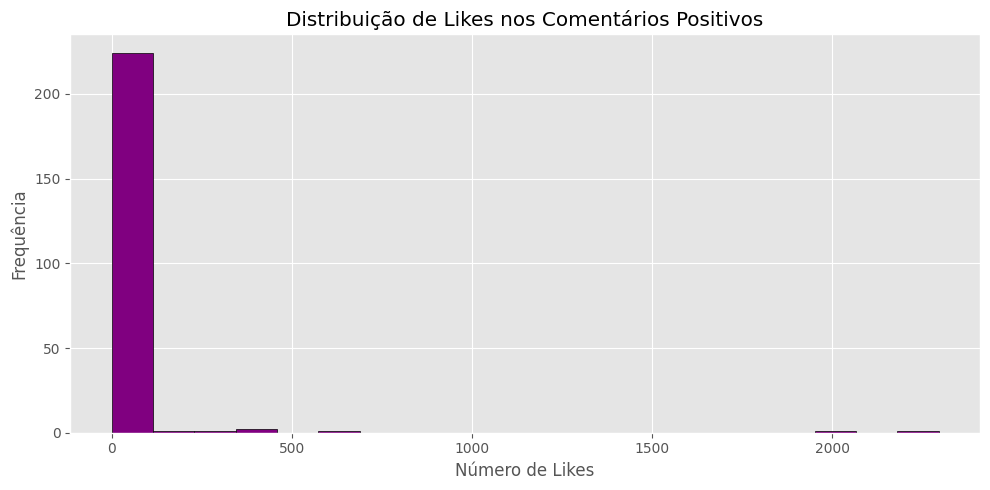

In [15]:
import csv
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Lista de palavras positivas conhecidas (sem mudanças)
PALAVRAS_POSITIVAS = {
    "incrível", "incrivel", "ótimo", "otimo", "maravilhoso", "excelente", "excel", 
    "fantástico", "fantastico", "perfeito", "impressionante", "sensacional", "sensac", 
    "espetacular", "notável", "notavel", "formidável", "formidavel", "excepcional", 
    "brilhante", "br", "fenomenal", "surpreendente", "surpreend", "único", "unico", 
    "extraordinário", "extraordinario", "magnífico", "magnifico", "estupendo", 
    "genial", "incomparável", "incomparavel", "impecável", "impecavel", "agradável", 
    "agradavel", "eficiente", "eficaz", "superior", "sup", "incrivelmente bom", 
    "divino", "encantador", "inspirador", "revolucionário", "revolucionario", 
    "exuberante", "radiante", "aproveitoso", "competente", "comp",
    "adorei", "adoro", "amei", "amo", "recomendo", "reco", "aprovado", "aprov", 
    "aprovei", "gostei", "gostei mto", "valeu a pena", "vlw a pena", "funciona", 
    "func", "surpreendeu", "superou expectativas", "sup expect", "parabéns", "parabens", 
    "pb", "top", "top d+", "show", "shoow", "demais", "d+", "irado", "sensação", 
    "sensac", "nota 10", "n10", "mandou bem", "mando bem", "arrasou", "chocou", 
    "fez diferença", "fez diff",
    "maneiro", "manero", "da hora", "dhr", "massa", "mssa", "foda", "fod", 
    "brabo", "brabo d+", "topzera", "firme", "firmeza", "animal", "anim", 
    "sinistro", "sinistro", "cabuloso", "cabrobr", "zica", "supimpa", "maravilindo", 
    "arretado", "arret",
    "econômico", "economico", "durável", "durave", "prático", "pratico", "rápido", 
    "rapido", "confiável", "confiavel", "moderno", "mod", "inovador", "customizável", 
    "customizavel", "intuitivo", "potente", "pot", "estiloso", "estilo", "confortável", 
    "confortavel", "sofisticado", "sofisti", "vibrante", "harmonioso",
    "mt bom", "mt bom", "mto bom", "top dms", "dms", "mto", "show d+", "incrivel d+"
}

# Lista de emojis positivos (pode ser estendida)
EMOJIS_POSITIVOS = {
    "😄", "😃", "😀", "😊", "😍", "🤩", "😂", "🤣", "👏", "👍",
    "💖", "🔥", "💯", "🙌", "😁", "🥰", "😎", "🎉", "✨", "😆"
}

# Função para analisar os sentimentos com base nas palavras e emojis positivos
def analisar_sentimentos_com_emoji(caminho_csv, coluna_comentario="comentario", coluna_likes="likes"):
    comentarios_positivos = []
    total_comentarios = 0
    total_positivos = 0
    likes_positivos = []

    with open(caminho_csv, mode='r', encoding='utf-8') as arquivo:
        leitor = csv.DictReader(arquivo)

        for linha in leitor:
            total_comentarios += 1
            comentario = linha[coluna_comentario]
            likes = int(linha[coluna_likes])  # Ou ajustar conforme a sua coluna de likes

            palavras_encontradas = set()

            # Detecção de palavras minúsculas positivas
            comentario_lower = comentario.lower()
            for palavra in PALAVRAS_POSITIVAS:
                if palavra in comentario_lower:
                    palavras_encontradas.add(palavra)

            # Detecção de palavras maiúsculas positivas
            palavras_maiusculas = re.findall(r'\b[A-ZÀ-Ú]{2,}\b', comentario)
            for palavra in palavras_maiusculas:
                if palavra.lower() in PALAVRAS_POSITIVAS:
                    palavras_encontradas.add(palavra.lower())

            # Detecção de emojis positivos
            emojis = re.findall(r'[^\w\s,]', comentario)  # Captura emojis e outros símbolos não alfanuméricos
            for emoji in emojis:
                if emoji in EMOJIS_POSITIVOS:
                    palavras_encontradas.add(emoji)

            if palavras_encontradas:
                total_positivos += 1
                comentarios_positivos.append({
                    "texto": comentario,
                    "palavras_chave": list(palavras_encontradas),
                    "likes": likes
                })
                likes_positivos.append(likes)

    # Calcular a média de likes dos comentários positivos
    media_likes_positivos = np.mean(likes_positivos) if likes_positivos else 0

    return {
        "total_comentarios": total_comentarios,
        "total_positivos": total_positivos,
        "media_likes_positivos": media_likes_positivos,
        "comentarios_positivos": comentarios_positivos
    }

# Caminho do CSV
caminho = "/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv"
resultado_com_sentimento = analisar_sentimentos_com_emoji(caminho, coluna_likes="likes")

# Exibição dos resultados
print(f"Total de comentários: {resultado_com_sentimento['total_comentarios']}")
print(f"Total positivos: {resultado_com_sentimento['total_positivos']}")
print(f"Média de Likes nos Comentários Positivos: {resultado_com_sentimento['media_likes_positivos']:.2f}")

# Visualização: Distribuição de likes nos comentários positivos
likes_positivos = [comentario["likes"] for comentario in resultado_com_sentimento['comentarios_positivos']]

plt.figure(figsize=(10, 5))
plt.hist(likes_positivos, bins=20, color='purple', edgecolor='black')
plt.xlabel('Número de Likes')
plt.ylabel('Frequência')
plt.title('Distribuição de Likes nos Comentários Positivos')
plt.tight_layout()
plt.show()


1. VADER analise de sentimento


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar o analisador de sentimentos
analisador = SentimentIntensityAnalyzer()

def analisar_sentimento(texto):
    # Obter o score de sentimento do comentário
    resultado = analisador.polarity_scores(texto)
    
    # Classificar o sentimento com base no score
    if resultado['compound'] >= 0.05:
        return 'Positivo'
    elif resultado['compound'] <= -0.05:
        return 'Negativo'
    else:
        return 'Neutro'

# Aplicar a função de análise de sentimentos
df['sentimento'] = df['comentario'].apply(analisar_sentimento)

# Exibir as primeiras linhas do dataframe com a coluna de sentimentos
print(df[['comentario', 'sentimento']].head())

from textblob import TextBlob

def analisar_emocoes(texto):
    # Usar o TextBlob para analisar a polaridade
    blob = TextBlob(texto)
    polaridade = blob.sentiment.polarity
    
    # Classificar emoções básicas com base na polaridade
    if polaridade > 0.2:
        return 'Felicidade'
    elif polaridade < -0.2:
        return 'Raiva'
    elif polaridade == 0:
        return 'Neutro'
    else:
        return 'Surpresa'

# Aplicar a função de análise de emoções
df['emocao'] = df['comentario'].apply(analisar_emocoes)

# Exibir as primeiras linhas do dataframe com as emoções
print(df[['comentario', 'emocao']].head())

from textblob import TextBlob

def analisar_emocoes(texto):
    # Usar o TextBlob para analisar a polaridade
    blob = TextBlob(texto)
    polaridade = blob.sentiment.polarity
    
    # Classificar emoções básicas com base na polaridade
    if polaridade > 0.2:
        return 'Felicidade'
    elif polaridade < -0.2:
        return 'Raiva'
    elif polaridade == 0:
        return 'Neutro'
    else:
        return 'Surpresa'

# Aplicar a função de análise de emoções
df['emocao'] = df['comentario'].apply(analisar_emocoes)

# Exibir as primeiras linhas do dataframe com as emoções
print(df[['comentario', 'emocao']].head())





                                          comentario sentimento
0                          51:30 GOLD. PEDRA DE GOLD     Neutro
1              Faye_tan, fazendo cosplay de smzinho?     Neutro
2                                            2:01:01     Neutro
3  descanse em paz ronaldinho, tao novo e já foi ...   Negativo
4  Sabrina Carpinteira do complexo de Israel kkkk...     Neutro
                                          comentario  emocao
0                          51:30 GOLD. PEDRA DE GOLD  Neutro
1              Faye_tan, fazendo cosplay de smzinho?  Neutro
2                                            2:01:01  Neutro
3  descanse em paz ronaldinho, tao novo e já foi ...  Neutro
4  Sabrina Carpinteira do complexo de Israel kkkk...  Neutro
                                          comentario  emocao
0                          51:30 GOLD. PEDRA DE GOLD  Neutro
1              Faye_tan, fazendo cosplay de smzinho?  Neutro
2                                            2:01:01  Neutro
3  des

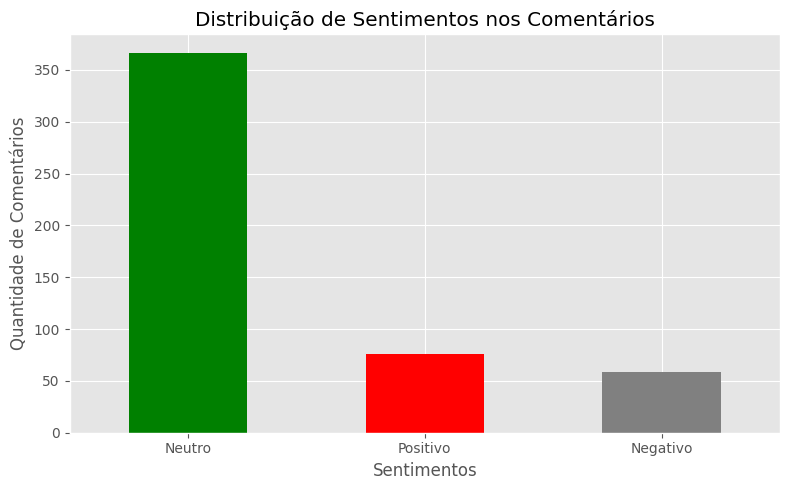

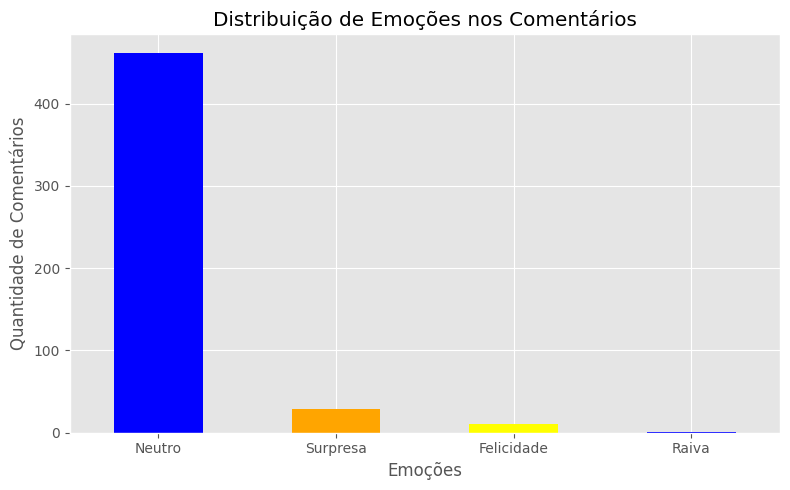

In [21]:
import matplotlib.pyplot as plt

# Análise de Sentimentos
sentimentos_contagem = df['sentimento'].value_counts()

# Gráfico de Sentimentos
plt.figure(figsize=(8, 5))
sentimentos_contagem.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Distribuição de Sentimentos nos Comentários')
plt.xlabel('Sentimentos')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Análise de Emoções
emocoes_contagem = df['emocao'].value_counts()

# Gráfico de Emoções
plt.figure(figsize=(8, 5))
emocoes_contagem.plot(kind='bar', color=['blue', 'orange', 'yellow'])
plt.title('Distribuição de Emoções nos Comentários')
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import re
from collections import defaultdict

# Lista de palavras positivas
PALAVRAS_POSITIVAS = {
    "incrível", "ótimo", "maravilhoso", "excelente", "fantástico", "perfeito", 
    "impressionante", "sensacional", "top", "fenômeno", "melhor"
}

# Função para calcular o engajamento
def analisar_engajamento(caminho_csv, coluna_comentario="comentario", coluna_likes="likes"):
    df = pd.read_csv(caminho_csv)
    comentarios_positivos = []
    total_comentarios = len(df)
    total_likes = 0
    total_positivos = 0
    likes_positivos = 0
    total_palavras_positivas = 0
    
    for index, linha in df.iterrows():
        comentario = linha[coluna_comentario].lower()
        likes = linha[coluna_likes]
        
        # Verificar palavras positivas
        palavras_encontradas = [p for p in PALAVRAS_POSITIVAS if p in comentario]
        
        if palavras_encontradas:
            total_positivos += 1
            likes_positivos += likes
            comentarios_positivos.append({
                "comentario": comentario,
                "likes": likes,
                "palavras_encontradas": palavras_encontradas
            })
        
        total_likes += likes
        total_palavras_positivas += len(palavras_encontradas)

    # Calcular métricas de engajamento
    media_likes_positivos = likes_positivos / total_positivos if total_positivos > 0 else 0
    taxa_engajamento = total_likes / total_comentarios if total_comentarios > 0 else 0

    return {
        "total_comentarios": total_comentarios,
        "total_positivos": total_positivos,
        "media_likes_positivos": media_likes_positivos,
        "taxa_engajamento": taxa_engajamento,
        "comentarios_positivos": comentarios_positivos,
        "total_likes": total_likes,
        "total_palavras_positivas": total_palavras_positivas
    }

# Caminho para o arquivo CSV
caminho_csv = "/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv"

# Executar a função de análise de engajamento
resultado_engajamento = analisar_engajamento(caminho_csv)

# Exibir os resultados
print(f"Total de comentários: {resultado_engajamento['total_comentarios']}")
print(f"Comentários positivos: {resultado_engajamento['total_positivos']}")
print(f"Média de likes nos comentários positivos: {resultado_engajamento['media_likes_positivos']}")
print(f"Taxa de engajamento (likes/comentários): {resultado_engajamento['taxa_engajamento']:.2f}")


Total de comentários: 501
Comentários positivos: 51
Média de likes nos comentários positivos: 57.35294117647059
Taxa de engajamento (likes/comentários): 15.30


In [4]:
caminho

NameError: name 'caminho' is not defined